In [1]:
# 1) 
!pip install numpy scipy pandas matplotlib scikit-learn

In [2]:
# 2) GPU-enabled PyTorch 2.4.0 + CUDA 12.4
!pip install \
  torch==2.4.0+cu124 \
  torchvision==0.19.0+cu124 \
  torchaudio==2.4.0+cu124 \
  --extra-index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.4.0%2Bcu124-cp311-cp311-linux_x86_64.whl (797.3 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.19.0%2Bcu124-cp311-cp311-linux_x86_64.whl (7.1 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.4.0%2Bcu124-cp311-cp311-linux_x86_64.whl (3.4 MB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cuda_nvrtc_cu12-12.4.99-py3-none-manylinux2014_x86_64.whl (24.7 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cuda_runtime_cu12-12.4.99-py3-none-manylinux2014_x86_64.whl (883 kB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cuda_cupti_cu12-12.4.99-py3-none-manylinux2014_x86_64.whl (13.8 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.w

In [3]:
# 3) PyG low-level CUDA kernels (must match torch+CUDA)
!pip install \
  pyg_lib \
  torch_scatter==2.1.2 \
  torch_sparse==0.6.17 \
  torch_cluster==1.6.1 \
  torch_spline_conv==1.2.2 \
  -f https://data.pyg.org/whl/torch-2.4.0+cu124.html


Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu124.html
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu124/pyg_lib-0.4.0%2Bpt24cu124-cp311-cp311-linux_x86_64.whl (2.5 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu124/torch_scatter-2.1.2%2Bpt24cu124-cp311-cp311-linux_x86_64.whl (10.7 MB)
  Using cached torch_sparse-0.6.17-cp311-cp311-linux_x86_64.whl
  Using cached torch_cluster-1.6.1-cp311-cp311-linux_x86_64.whl
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu124/torch_spline_conv-1.2.2%2Bpt24cu124-cp311-cp311-linux_x86_64.whl (995 kB)


In [4]:
# 4) PyG high-level libraries
!pip install \
  torch-geometric==2.3.1 \
  torch-geometric-temporal==0.54.0

  Using cached torch_geometric-2.3.1-py3-none-any.whl
  Using cached torch_geometric_temporal-0.54.0-py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached pandas-1.3.5-cp311-cp311-linux_x86_64.whl
Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1


In [5]:
import torch, torch_geometric, torch_geometric_temporal as tgt

In [6]:
print("Torch:", torch.__version__,
      "| CUDA:", torch.version.cuda,
      "| GPU available:", torch.cuda.is_available())
print("PyG:", torch_geometric.__version__)
print("PyG-Temporal:", tgt.__version__)

Torch: 2.4.0+cu124 | CUDA: 12.4 | GPU available: True
PyG: 2.3.1
PyG-Temporal: 0.54.0


In [7]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import OneCycleLR
import torch_geometric
import torch_geometric_temporal as tgt
from torch_geometric.data import HeteroData
from torch_geometric_temporal.signal import DynamicHeteroGraphTemporalSignal
from torch_geometric_temporal.nn.hetero import HeteroGCLSTM
import copy
import matplotlib.pyplot as plt


In [8]:
# Global settings:
seed = 42
window_size = 10
n_epochs = 50  
hidden_dim = 128
initial_lr = 1e-4
weight_decay_val = 1e-2
max_lr_onecycle = 1e-3
pct_start_onecycle = 0.1


In [9]:
# Reproducibility:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [28]:
#1) Loading single measurement:

def load_and_process_single_measurement(sats_csv_path, receiver_csv_path):
    sats_df = pd.read_csv(sats_csv_path)
    rec_df  = pd.read_csv(receiver_csv_path)
    t_ids   = sorted(rec_df['T_ID'].unique())

    #lists to collect per-timestep data
    feature_dicts = []
    target_dicts  = []
    edge_index_dicts = []
    satellite_id_dicts = []

    for t in t_ids:
        #grabbing the recievers features and target values
        rec_row = rec_df[rec_df['T_ID'] == t].iloc[0]   
        feat_rec = rec_row[['Lat', 'Lon']].to_numpy().reshape(1, 2)
        targ_rec = rec_row[['LatDev', 'LonDev']].to_numpy().reshape(1, 2)
        
        #visible satellites at that timestep (features+IDs)
        sats_t = sats_df[sats_df['T_ID'] == t].sort_values('S_ID')
        n_sat  = len(sats_t)
        feat_sat = sats_t[['SNR', 'az', 'el']].to_numpy().reshape(n_sat, 3)
        s_ids_sat = sats_t['S_ID'].values.astype(np.int64)

        src = np.zeros(n_sat, dtype=int)
        dst = np.arange(n_sat, dtype=int)
        edges = np.vstack([src, dst])           #building edges from the reciever to visible satellites
        edges_rev = edges[::-1].copy()         # revdrsing to get satellite-reciever edges

        feature_dicts.append({
            'receiver': feat_rec,
            'satellite': feat_sat
        })
        target_dicts.append({'receiver': targ_rec})
        edge_index_dicts.append({
            ('receiver','to','satellite'):      edges,
            ('satellite','rev_to','receiver'): edges_rev
        })
        satellite_id_dicts.append({'satellite_s_ids': s_ids_sat})

    edge_weight_dicts = [None] * len(feature_dicts)


    return feature_dicts, target_dicts, edge_index_dicts, edge_weight_dicts, satellite_id_dicts

In [30]:
#2) Loading all measurements

base_path = "/home/jovyan/shared/Ivana_GNN/Sateliti/parsed/Ublox10/cw/-65/"

measurement_definitions = [
    {
        "id":       f"R_{i}",
        "sats":     os.path.join(base_path, f"R_{i}", "sats_data.csv"),
        "receiver": os.path.join(base_path, f"R_{i}", "reciever_data.csv"),
    }
    for i in range(50)
]

all_measurements_processed = []

for m_info in measurement_definitions:
    sats_path = m_info["sats"]
    rec_path  = m_info["receiver"]

    if not (os.path.exists(sats_path) and os.path.exists(rec_path)):
        print(f"  UPOZORENJE: Datoteke za {m_info['id']} ne postoje.")
        continue


    features, targets, edges, weights, additional_sids_dicts = \
        load_and_process_single_measurement(sats_path, rec_path)

    all_measurements_processed.append({
        "id":               m_info["id"],
        "features":         features,              # List[Dict{'receiver': (1×2), 'satellite': (n_sat×3)}]
        "targets":          targets,               # List[Dict{'receiver': (1×2)}]
        "edges":            edges,                 # List[Dict{('receiver','to','satellite'): (2×n_sat), …}]
        "weights":          weights,               # List[None], jedan None po timestampu
        "time_steps":       times,                 # List[int], T_ID vrijednosti po vremenu
        "satellite_s_ids":  additional_sids_dicts   # List[Dict{'satellite_s_ids': array(n_sat,)}]
    })

if not all_measurements_processed:
    raise ValueError(
        "Nijedno mjerenje nije učitano.")

# Change for different splits:
train_measurements_data = all_measurements_processed[:25]
test_measurements_data  = all_measurements_processed[25:]

print(f"Ukupno ucitanih mjerenja: {len(all_measurements_processed)}")
print(f"  Za trening: {len(train_measurements_data)}  (IDs: {[m['id'] for m in train_measurements_data]})")
print(f"  Za test:    {len(test_measurements_data)}  (IDs: {[m['id'] for m in test_measurements_data]})")


Ukupno učitanih mjerenja: 50
  Za trening: 25  (IDs: ['R_0', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24'])
  Za test:    25  (IDs: ['R_25', 'R_26', 'R_27', 'R_28', 'R_29', 'R_30', 'R_31', 'R_32', 'R_33', 'R_34', 'R_35', 'R_36', 'R_37', 'R_38', 'R_39', 'R_40', 'R_41', 'R_42', 'R_43', 'R_44', 'R_45', 'R_46', 'R_47', 'R_48', 'R_49'])


In [32]:
# 3) Aggregation of the training data

agg_train_rec_feats = []   
agg_train_sat_feats = []   
agg_train_targ_rec  = []   

for meas_data in train_measurements_data:
    for feat_dict, targ_dict in zip(meas_data["features"], meas_data["targets"]):

        fr = feat_dict['receiver']
        agg_train_rec_feats.append(fr)

        fs = feat_dict['satellite']
        if fs.size > 0:
            agg_train_sat_feats.append(fs)

        tr = targ_dict['receiver']
        agg_train_targ_rec.append(tr)


rec_feats_np = np.vstack(agg_train_rec_feats)
sat_feats_np = np.vstack(agg_train_sat_feats)
targ_rec_np  = np.vstack(agg_train_targ_rec)


In [33]:
#4) Fit StandardScalers on TRAINING data 

rec_scaler  = StandardScaler().fit(rec_feats_np)
targ_scaler = StandardScaler().fit(targ_rec_np)
sat_scaler  = StandardScaler().fit(sat_feats_np)


#5) Normalization function
def normalize_with_scalers(measurement_data_list, rec_scaler, sat_scaler, targ_scaler):
    normalized_measurements = []
    for meas_data in measurement_data_list:
        norm_feat_dicts = []
        norm_targ_dicts = []
        norm_sids_list  = []

        num_ts = len(meas_data["features"])
        for i in range(num_ts):
            fr   = meas_data["features"][i]['receiver']
            fs   = meas_data["features"][i]['satellite']
            sids = meas_data["satellite_s_ids"][i]['satellite_s_ids']
            tr   = meas_data["targets"][i]['receiver']

            norm_fr = rec_scaler.transform(fr)
            norm_tr = targ_scaler.transform(tr)

            if fs.size > 0:
                norm_fs = sat_scaler.transform(fs)
            else:
                norm_fs = fs.copy()

            norm_feat_dicts.append({
                'receiver':  norm_fr,
                'satellite': norm_fs
            })
            norm_targ_dicts.append({
                'receiver':  norm_tr
            })
            norm_sids_list.append({'satellite_s_ids': sids.copy()})

        new_meas = {
            **meas_data,
            "features":        norm_feat_dicts,
            "targets":         norm_targ_dicts,
            "satellite_s_ids": norm_sids_list
        }
        normalized_measurements.append(new_meas)

    return normalized_measurements

In [34]:
#6) Apply normalization to train & test

normalized_train_measurements = normalize_with_scalers(
    train_measurements_data, rec_scaler, sat_scaler, targ_scaler
)
normalized_test_measurements  = normalize_with_scalers(
    test_measurements_data, rec_scaler, sat_scaler, targ_scaler
)


In [18]:
#7) Create DynamicHeteroGraphTemporalSignal

def create_signals(measurements, split_name):
    '''
    Creating HeteroData objects for each timstamp/snapshot 
    '''
    signals = []
    for meas_data in measurements:
        signal = DynamicHeteroGraphTemporalSignal(
            edge_index_dicts   = meas_data["edges"],
            edge_weight_dicts  = meas_data["weights"],
            feature_dicts      = meas_data["features"],
            target_dicts       = meas_data["targets"],
            satellite_s_ids    = meas_data["satellite_s_ids"]
        )
        signals.append(signal)
        #print(f"Created {split_name} signal {meas_data['id']} (snapshots: {signal.snapshot_count})")
    return signals

# Create temporal signals for all normalized TRAIN measurements
train_signals = create_signals(normalized_train_measurements, "train")

# Create temporal signals for all normalized TEST measurements
test_signals = create_signals(normalized_test_measurements, "test")



DEBUG: Creating DynamicHeteroGraphTemporalSignal objects...
DEBUG: Finished creating DynamicHeteroGraphTemporalSignal objects.


In [35]:
#8) Sliding‐window Dataset & DataLoader
'''
    Building a PyTorch Dataset that generates sliding windows containing HeteroData snapshots,
    and both test and train loaders
    
'''

class SlidingWindowDataset(Dataset):
    def __init__(self, signal, window_size, stride=1):
        self.signal = signal
        self.window_size = window_size
        self.stride = stride

    def __len__(self):
        # Number of windows given this stride
        return max(0, (self.signal.snapshot_count - self.window_size) // self.stride + 1)

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size
        return [self.signal[t] for t in range(start, end)]

def build_loader(signals, shuffle, stride=1):
    datasets = []
    for sig in signals:
        ds = SlidingWindowDataset(sig, window_size, stride=stride)
        if len(ds) > 0:
            datasets.append(ds)
    if not datasets:
        return None
    concat = ConcatDataset(datasets)
    return DataLoader(
        concat,
        batch_size=1,
        shuffle=shuffle,
        collate_fn=lambda batch: batch[0]
    )

# Choose stride for (non‐)overlapping windows:
train_loader = build_loader(train_signals, shuffle=True,  stride=window_size)
test_loader  = build_loader(test_signals,  shuffle=False, stride=window_size)


'''
if train_loader is None or len(train_loader.dataset) == 0:
    raise ValueError("No training windows after sliding‐window split.")
print(f"DEBUG: Train DataLoader created. Total windows: {len(train_loader.dataset)}")

if test_loader is None or len(test_loader.dataset) == 0:
    print("DEBUG: No test windows available; skipping test DataLoader creation.")
else:
    print(f"DEBUG: Test DataLoader created. Total windows: {len(test_loader.dataset)}")
'''

num_train_windows_total = len(train_loader.dataset)
num_test_windows_total = len(test_loader.dataset)

total_steps = n_epochs * num_train_windows_total

print(f" Total training steps: n_epochs={n_epochs}, num_train_windows_total={num_train_windows_total}")
print(f" Total training steps: n_epochs={n_epochs}, num_test_windows_total={num_test_windows_total}")

print(f" total_steps = {total_steps}")

 Total training steps: n_epochs=50, num_train_windows_total=700
 Total training steps: n_epochs=50, num_test_windows_total=700
 total_steps = 35000


In [38]:
#9) Define function for iterating the GCLSTM cell through all snapshots in the window

def run_window(window_snapshots, model, hidden_dim, device):
    '''
    window_Snapshots: list of HeteroData objects 
    model:            Model (defined in the cell below)
    hidden_dim:       int
    device:           torch.device

    Returns:
      pred_norm: (1x2) tensor - normalized lat/lon predictions for last snapshot
      true_norm: (1x2) tensor - ground truth for last snapshot
    '''
    h_state = {'receiver': torch.zeros(hidden_dim, device=device)}
    c_state = {'receiver': torch.zeros(hidden_dim, device=device)}

    for snapshot in window_snapshots:
        x_dict_for_gclstm = {
            'receiver': snapshot.x_dict['receiver'].to(device),
            'satellite': snapshot.x_dict['satellite'].to(device)
        }
        eidx_on_device = {
            rel: snapshot.edge_index_dict[rel].to(device)
            for rel in snapshot.edge_index_dict
        }

        rec_h = h_state['receiver'].unsqueeze(0)  
        rec_c = c_state['receiver'].unsqueeze(0)

        s_ids_val = snapshot['satellite_s_ids']['satellite_s_ids']
        if isinstance(s_ids_val, torch.Tensor):
            s_ids_np = s_ids_val.cpu().numpy()
        else:
            s_ids_np = np.array(s_ids_val, dtype=np.int64)
        num_sat = len(s_ids_np)

        h_sat = torch.zeros((num_sat, hidden_dim), device=device)
        c_sat = torch.zeros((num_sat, hidden_dim), device=device)
        for j, sid in enumerate(s_ids_np):
            if sid in h_state:
                h_sat[j] = h_state[sid]
                c_sat[j] = c_state[sid]

        h_dict_step = {'receiver': rec_h, 'satellite': h_sat}
        c_dict_step = {'receiver': rec_c, 'satellite': c_sat}

        h_out, c_out = model.gclstm(x_dict_for_gclstm, eidx_on_device, h_dict_step, c_dict_step)

        h_state['receiver'] = h_out['receiver'][0]
        c_state['receiver'] = c_out['receiver'][0]
        for j, sid in enumerate(s_ids_np.tolist()):
            h_state[sid] = h_out['satellite'][j]
            c_state[sid] = c_out['satellite'][j]

    h_final = h_state['receiver'].unsqueeze(0)  
    h_dropped = model.dropout(h_final)
    pred_norm = torch.cat([model.lin_lat(h_dropped), model.lin_lon(h_dropped)], dim=-1)  

    true_norm = window_snapshots[-1].y_dict['receiver'].to(device)  
    return pred_norm, true_norm



In [39]:
# 10) Define the Model 

class Model(nn.Module):
    def __init__(self, in_channels_dict, hidden_dim, metadata, dropout_rate=0.1):
        super().__init__()
        self.gclstm = HeteroGCLSTM(
            in_channels_dict = in_channels_dict,
            out_channels      = hidden_dim,
            metadata          = metadata
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.lin_lat  = nn.Linear(hidden_dim, 1)
        self.lin_lon  = nn.Linear(hidden_dim, 1)

    def forward(self, x_dict, edge_index_dict, h_dict=None, c_dict=None):
        h_out, c_out = self.gclstm(x_dict, edge_index_dict, h_dict, c_dict)
        h_rec = h_out['receiver']  
        h_rec = self.dropout(h_rec)
        coords = torch.cat([self.lin_lat(h_rec), self.lin_lon(h_rec)], dim=-1) 
        return coords, h_out, c_out


In [40]:
# 11) Initialize model, optimizer, loss, scheduler

if not train_signals or train_signals[0].snapshot_count == 0:
    raise ValueError("No training signals or first signal is empty for metadata.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

model = Model(
    in_channels_dict = {'receiver': 2, 'satellite': 3},
    hidden_dim       = hidden_dim,
    metadata         = train_signals[0][0].metadata()
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay_val
)
loss_fn = nn.SmoothL1Loss(beta=1e-2)

scheduler = OneCycleLR(
    optimizer,
    max_lr = max_lr_onecycle,
    total_steps = total_steps,
    pct_start = pct_start_onecycle,
    anneal_strategy = 'cos'
)



 Using device: cuda


In [23]:
# 12) Training & evaluation loop

train_losses_epochs, test_losses_epochs, mae_sums_epochs = [], [], []
best_test_loss = float('inf')
best_epoch_metrics = {}
best_model_state = None

print("Beginning training...")
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs} — Start training")
    model.train()
    total_train_loss_epoch = 0.0

    if train_loader is None or len(train_loader.dataset) == 0:
        print(f"Epoch {epoch:03d} — Training skipped (empty train_loader).")
        train_losses_epochs.append(float('nan'))
        test_losses_epochs.append(float('nan'))
        mae_sums_epochs.append(float('nan'))
        continue

    # train
    for window_snapshots in train_loader:
        optimizer.zero_grad()
        pred_norm, true_norm = run_window(window_snapshots, model, hidden_dim, device)
        lat_p, lon_p = pred_norm[:, 0], pred_norm[:, 1]
        lat_t, lon_t = true_norm[:, 0], true_norm[:, 1]

        loss_lat = loss_fn(lat_p.unsqueeze(1), lat_t.unsqueeze(1))
        loss_lon = loss_fn(lon_p.unsqueeze(1), lon_t.unsqueeze(1))
        loss = loss_lat + loss_lon

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_train_loss_epoch += loss.item()

    avg_train_loss_epoch = total_train_loss_epoch / len(train_loader)
    train_losses_epochs.append(avg_train_loss_epoch)

    # eval
    if test_loader is not None and len(test_loader.dataset) > 0:
        model.eval()
        total_test_loss_epoch = 0.0
        abs_errs_epoch = []

        with torch.no_grad():
            for window_snapshots_test in test_loader:
                pred_norm_test, true_norm_test = run_window(window_snapshots_test, model, hidden_dim, device)
                lat_p_t, lon_p_t = pred_norm_test[:, 0], pred_norm_test[:, 1]
                lat_t_t, lon_t_t = true_norm_test[:, 0], true_norm_test[:, 1]

                lt = loss_fn(lat_p_t.unsqueeze(1), lat_t_t.unsqueeze(1))
                ln = loss_fn(lon_p_t.unsqueeze(1), lon_t_t.unsqueeze(1))
                total_test_loss_epoch += (lt + ln).item()

                # un-normalize za MAE
                pred_cm = pred_norm_test.cpu().numpy() * targ_scaler.scale_ + targ_scaler.mean_
                true_cm = true_norm_test.cpu().numpy() * targ_scaler.scale_ + targ_scaler.mean_
                abs_errs_epoch.append(np.abs(pred_cm - true_cm))

        avg_test_loss_epoch = total_test_loss_epoch / len(test_loader)
        test_losses_epochs.append(avg_test_loss_epoch)

        if abs_errs_epoch:
            errors_epoch = np.vstack(abs_errs_epoch)
            mae_lat_epoch = errors_epoch[:, 0].mean()
            mae_lon_epoch = errors_epoch[:, 1].mean()
            mae_sum_epoch = mae_lat_epoch + mae_lon_epoch
            mae_sums_epochs.append(mae_sum_epoch)

            print(
                f"Epoch {epoch:03d} — "
                f"Train Loss: {avg_train_loss_epoch:.4f}, "
                f"Test Loss: {avg_test_loss_epoch:.4f} — "
                f"MAE Lat: {mae_lat_epoch:.2f} cm, "
                f"Lon: {mae_lon_epoch:.2f} cm "
                f"(sum: {mae_sum_epoch:.2f} cm)"
            )

            if avg_test_loss_epoch < best_test_loss:
                best_test_loss = avg_test_loss_epoch
                best_epoch_metrics = {
                    'epoch': epoch,
                    'test_loss': avg_test_loss_epoch,
                    'mae_lat': mae_lat_epoch,
                    'mae_lon': mae_lon_epoch,
                    'mae_sum': mae_sum_epoch
                }
                best_model_state = copy.deepcopy(model.state_dict())
                torch.save(best_model_state, 'best_model.pth')
                print(f"   >> Best model updated.")
        else:
            mae_sums_epochs.append(float('nan'))
            print(
                f"Epoch {epoch:03d} — "
                f"Train Loss: {avg_train_loss_epoch:.4f}, "
                f"Test Loss: {avg_test_loss_epoch:.4f} (No MAE)"
            )
    else:
        test_losses_epochs.append(float('nan'))
        mae_sums_epochs.append(float('nan'))
        print(f"Epoch {epoch:03d} — Train Loss: {avg_train_loss_epoch:.4f} (Test skipped)")

if best_epoch_metrics:
    print("\n--- Best performance on test set ---")
    print(f"Epoch: {best_epoch_metrics['epoch']}")
    print(f"Test Loss: {best_epoch_metrics['test_loss']:.4f}")
    print(
        f"MAE Lat: {best_epoch_metrics['mae_lat']:.2f} cm, "
        f"Lon: {best_epoch_metrics['mae_lon']:.2f} cm "
        f"(sum: {best_epoch_metrics['mae_sum']:.2f} cm)"
    )
    print("Best model saved as 'best_model.pth'")


DEBUG: Starting training loop...
Beginning training...
Epoch 1/50 — Start training
Epoch 001 — Train Loss: 1.1225, Test Loss: 0.4176 — MAE Lat: 5.66 cm, Lon: 5.35 cm (sum: 11.01 cm)
   >> Best model updated.
Epoch 2/50 — Start training
Epoch 002 — Train Loss: 0.2913, Test Loss: 0.2280 — MAE Lat: 2.83 cm, Lon: 3.28 cm (sum: 6.12 cm)
   >> Best model updated.
Epoch 3/50 — Start training
Epoch 003 — Train Loss: 0.1869, Test Loss: 0.1667 — MAE Lat: 1.96 cm, Lon: 2.57 cm (sum: 4.54 cm)
   >> Best model updated.
Epoch 4/50 — Start training
Epoch 004 — Train Loss: 0.1520, Test Loss: 0.2174 — MAE Lat: 2.93 cm, Lon: 2.92 cm (sum: 5.85 cm)
Epoch 5/50 — Start training
Epoch 005 — Train Loss: 0.1394, Test Loss: 0.1045 — MAE Lat: 1.22 cm, Lon: 1.71 cm (sum: 2.93 cm)
   >> Best model updated.
Epoch 6/50 — Start training
Epoch 006 — Train Loss: 0.1337, Test Loss: 0.1113 — MAE Lat: 1.53 cm, Lon: 1.58 cm (sum: 3.11 cm)
Epoch 7/50 — Start training
Epoch 007 — Train Loss: 0.1360, Test Loss: 0.0880 — MAE 

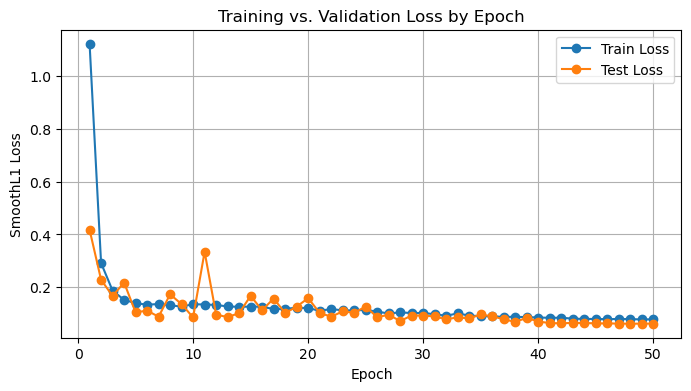

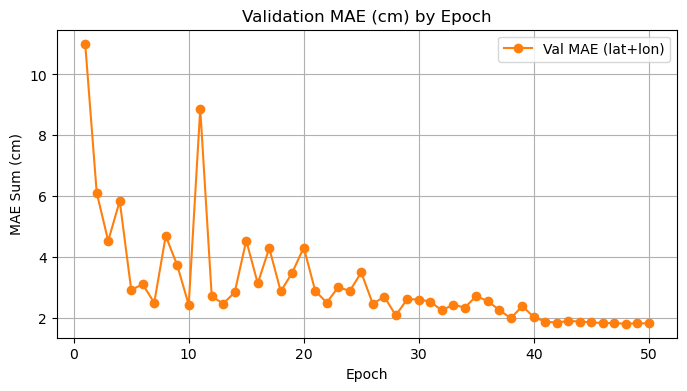

In [24]:

# 13) Plot loss and MAE curves
epochs = list(range(1, n_epochs + 1))

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses_epochs, marker='o', label='Train Loss')
plt.plot(epochs, test_losses_epochs,  marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('SmoothL1 Loss')
plt.title('Training vs. Validation Loss by Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, mae_sums_epochs, marker='o', color='tab:orange', label='Val MAE (lat+lon)')
plt.xlabel('Epoch')
plt.ylabel('MAE Sum (cm)')
plt.title('Validation MAE (cm) by Epoch')
plt.legend()
plt.grid(True)
plt.show()